<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/SLC_VI_lenet_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import shutil
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
!nvidia-smi

Thu Sep  8 21:53:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
shutil.rmtree('bnn_hmc', ignore_errors=True)

In [5]:
!git clone https://github.com/adammoss/bnn_hmc

Cloning into 'bnn_hmc'...
remote: Enumerating objects: 664, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 664 (delta 88), reused 34 (delta 14), pack-reused 531
Receiving objects: 100% (664/664), 1.30 MiB | 10.07 MiB/s, done.
Resolving deltas: 100% (469/469), done.


In [6]:
# https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl
!pip install jax==0.2.12
!pip install dm-haiku==0.0.5.dev0 optax==0.0.6 chex==0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl (189.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
for i, root in enumerate(glob.glob('/content/runs/*/')):
  shutil.rmtree(root, ignore_errors=True)

In [11]:
!python3 bnn_hmc/scripts/run_vi.py --seed=1 --weight_decay=5. --dir=runs/vi/slc/ \
  --dataset_name=slc/space --model_name=lenet \
  --init_step_size=1e-4 --num_epochs=200 --eval_freq=5 --batch_size=50 --patience 10\
  --save_freq=300 --optimizer=Adam \
  --vi_sigma_init=0.01 --temperature=1. --vi_ensemble_size=20 --train_split=train[:80%] --test_split=train[80%:] --image_size=64

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Starting from random initialization with provided seed
/content/bnn_hmc/bnn_hmc/utils/script_utils.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, test_set))
/content/bnn_hmc/bnn_hmc/utils/script_utils.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, train_set))
bnn_hmc/scripts/run_vi.py:199: Visi

In [12]:
!python3 bnn_hmc/scripts/run_vi.py --seed=1 --weight_decay=5. --dir=runs/vi/slc/ \
  --dataset_name=slc/space --model_name=lenet \
  --init_step_size=1e-4 --num_epochs=200 --eval_freq=5 --batch_size=50 --patience 10\
  --save_freq=300 --optimizer=Adam \
  --vi_sigma_init=0.01 --temperature=1. --vi_ensemble_size=20 --eval_split=test --image_size=64

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Continuing the run from the last saved checkpoint
bnn_hmc/scripts/run_vi.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vi_ensemble_predict_fn(net_apply, params, net_state, test_set))
{'accuracy': DeviceArray(0.68365, dtype=float32), 'nll': 0.57625204, 'ece': 0.1045352579638362}


In [14]:
accuracies = []
nlls = []
eces = []
softmax = []
for i, root in enumerate(glob.glob('/content/runs/vi/slc/*/')):
  data = np.load(root + '/test_set.npy')  
  softmax = np.squeeze(np.load(root + '/predictions.npy'))
  metrics = np.load(root + '/metrics.npy', allow_pickle=True)
  accuracies.append(metrics.item()['accuracy'])
  nlls.append(metrics.item()['nll'])
  eces.append(metrics.item()['ece'])
print('Accuracy', np.mean(accuracies), np.std(accuracies))
print('NLL', np.mean(nlls), np.std(nlls))
print('ECE', np.mean(eces), np.std(eces))

Accuracy 0.68365 0.0
NLL 0.57625204 0.0
ECE 0.1045352579638362 0.0


In [15]:
print('Ensemble accuracy', np.sum(np.argmax(np.mean(softmax, axis=0), axis=-1) == data) / softmax.shape[1])

Ensemble accuracy 0.68365


In [16]:
def uncertainty(softmax):
  # Per example softmax with shape(num_examples, num_classes)
  predictive_entropy = 0
  single_pass_entropy = 0
  for i in range(softmax.shape[1]):
    # Sum over classes
    predictive_entropy += -np.mean(softmax[:,i])*np.log(np.mean(softmax[:,i]))
    single_pass_entropy += -softmax[:,i]*np.log(softmax[:,i])
  single_pass_entropy = np.mean(single_pass_entropy)
  mutual_info = predictive_entropy - single_pass_entropy
  return predictive_entropy, single_pass_entropy, mutual_info

In [21]:
predictive_entropies = [] 
single_pass_entropies = []
mutual_infos = []
for i in range(softmax.shape[1]):
  predictive_entropy, single_pass_entropy, mutual_info = uncertainty(softmax[:,i,:])
  if np.isnan(predictive_entropy) or np.isnan(single_pass_entropy):
    continue
  predictive_entropies.append(predictive_entropy)
  single_pass_entropies.append(single_pass_entropy)
  mutual_infos.append(mutual_info)
print('Predictive entropy:', np.mean(predictive_entropies), np.std(predictive_entropies))
print('Single pass entropy:', np.mean(single_pass_entropies), np.std(single_pass_entropies))
print('Mutual info:', np.mean(mutual_infos), np.std(mutual_infos))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in float_scalars
  import sys


Predictive entropy: 0.42674828902120543 0.24025700687081103
Single pass entropy: 0.39054996 0.22319326
Mutual info: 0.03619831967433948 0.03191993950992187


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


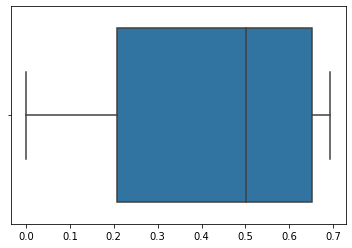

In [22]:
sns.boxplot(predictive_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


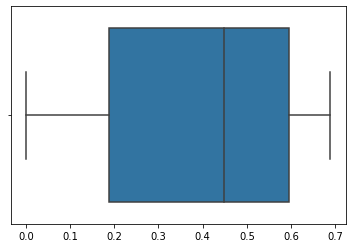

In [23]:
sns.boxplot(single_pass_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


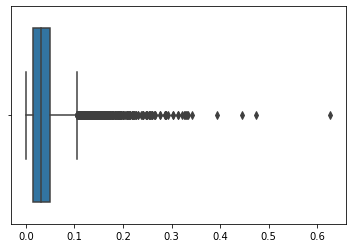

In [24]:
sns.boxplot(mutual_infos)
plt.show()